In [1]:
from rdflib import Graph, Namespace, Literal, BNode, URIRef
import os
import getpass
from langchain.document_loaders import TextLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.schema import Document
from sklearn.cluster import KMeans
import json

In [2]:
os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key:')

In [3]:
# Load jsonld file
data = json.load(open("data/dunbar/bacnet.jsonld"))

In [4]:
# Create the documents to load into the vector store
documents = []

# Loop through the jsonld file and create a document for each
for i in range(0, len(data)):
    # Check if its a bacnet device or point
    type = data[i]["@type"][0]
    if type == "http://data.ashrae.org/bacnet/2016#bacnet_Point":
        device_name = data[i]['http://data.ashrae.org/bacnet/2016#device_name'][0]['@value']
        point_name = data[i]['http://data.ashrae.org/bacnet/2016#object_name'][0]['@value']
        present_value = data[i]['http://data.ashrae.org/bacnet/2016#present_value'][0]['@value']
        unit = data[i]['http://data.ashrae.org/bacnet/2016#object_units'][0]['@value']

        # Create the document
        content = point_name + " " + present_value + " " + unit
        # documents.append(Document(page_content=content, metadata={"type": "bacnet_point", }))
    elif type == "http://data.ashrae.org/bacnet/2016#bacnet_Device":
        device_name = data[i]['http://data.ashrae.org/bacnet/2016#device_name'][0]['@value']

        # Create the document
        content = device_name
        documents.append(Document(page_content=content, metadata={"type": "bacnet_device"}))

In [5]:
# Load the documents into the vector store
db = Chroma.from_documents(documents, OpenAIEmbeddings())

In [6]:
vectorstore_data = db.get(include=["embeddings", "metadatas"])
embs = vectorstore_data["embeddings"]

In [10]:
# Computer required parameters of DBSCAN clustering
# Use KNN to find the optimal epsilon
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Find the optimal epsilon
nbrs = NearestNeighbors(n_neighbors=5).fit(embs)

distances, indices = nbrs.kneighbors(embs)

distances = np.sort(distances, axis=0)

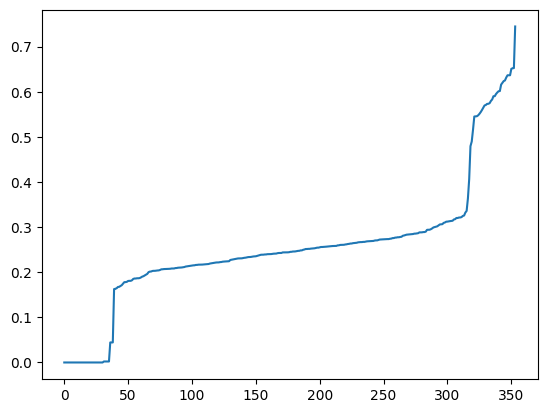

In [16]:
# Now, get the sorted kth column (distances with kth neighbors) and plot the kNN distance plot
import matplotlib.pyplot as plt

plt.plot(distances[:, 4])
plt.show()

In [17]:
# Use knee locator to find the optimal epsilon
from kneed import KneeLocator

kneedle = KneeLocator(
    range(1, distances.shape[0] + 1), distances[:, 1], curve="convex", direction="increasing"
)

kneedle.knee_y

0.3015982311836857

In [27]:
# Compute the DBSCAN clustering
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=5).fit(embs)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Print the results
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 7
Estimated number of noise points: 47


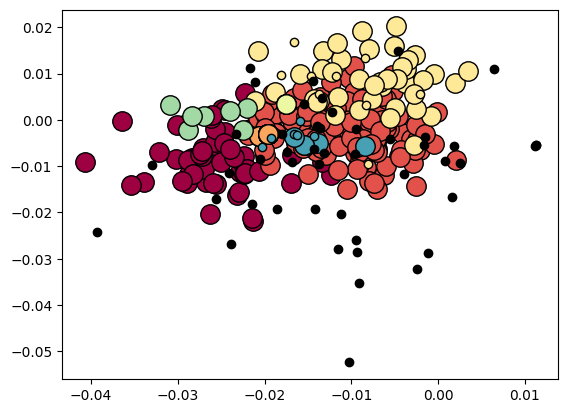

In [32]:
# Plot the results
import matplotlib.pyplot as plt

unique_labels = set(labels)
embs = np.array(embs)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = embs[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = embs[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6) 

In [51]:
# Create a dict of clusters and their bacnet devices
clusters = {}
for i in range(0, len(labels)):
    if labels[i] in clusters:
        clusters[labels[i]].append(documents[i].page_content)
    else:
        clusters[labels[i]] = [documents[i].page_content]

# Print the clusters
print(clusters[0])

['VAV-D2-6', 'VAV-D2-24', 'VAV-D2-27', 'VAV-D2-14', 'VAV-D2-37', 'VAV-D2-39', 'VAV-D2-41', 'VAV-D2-11', 'VAV-A3-1', 'VAV-D2-43', 'VAV-D2-53', 'VAV-D2-52', 'VAV-D2-46', 'VAV-D2-8', 'VAV-D2-40', 'VAV-D2-44', 'VAV-D2-12', 'VAV-D2-10', 'VAV-D2-19', 'VAV-D2-32', 'VAV-D2-13', 'VAV-D2-16', 'VAV-D2-33', 'VAV-D2-21', 'VAV-D2-5', 'VAV-D2-1', 'VAV-D2-17', 'VAV-D2-45', 'VAV-D2-15', 'VAV-D2-18', 'VAV-D2-38', 'VAV-D2-42', 'VAV-D2-51', 'VAV-D2-20', 'VAV-D2-54', 'VAV-D2-28', 'VAV-D2-23', 'VAV-D2-29', 'VAV-D2-48', 'VAV-D2-49', 'VAV-D2-25', 'VAV-D2-4', 'VAV-D2-47', 'VAV-D2-30', 'VAV-D2-50', 'VAV-D2-22', 'VAV-D2-26', 'VAV-D2-2', 'VAV-D2-56', 'VAV-D2-31', 'VAV-D2-7', 'VAV-D2-55', 'VAV-D2-34', 'VAV-D2-35', 'VAV-D2-3', 'VAV-D2-36', 'VAV-D2-9']
